<a href="https://colab.research.google.com/github/vanderbilt-ml/51-boyce-mlproj-NIDS/blob/main/NIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Network Intrusion Detection System Classifier

###Background
Network Intrusion Detections Systems (NIDS) have been used in network defense for quite some time. It is of great importance, however, to keep NIDS systems updated to identify new and evolving attack types. Researchers at the University of Queensland, Australia have produced consolidated datasets to include attacks against IoT devices and data comprising attacks against multiple test networks. Of particular interest here as well is that the data is, essentially, brand new. 

###Description
The work in this project will focus on using the provided data to create a Machine Learning model that can be used to create a NIDS in my home lab. This is something I have wanted to do for quite some time. I do not have any IoT devices running in the lab at the moment but may in the future and will aply the IoT data here as well.

###Metric
For now, the goal will be to classify traffic reflected in the dataset - bot, recon, worm, etc - with a score of 60% to allow for human intervention/triage. At the moment, I'm not too worried about DoS as I do not think anyone is DoS'ing me.

###Sources
Per the request of the researchers in using the data for academic purposes, the following papers are cited:

Sarhan, M., Layeghy, S. & Portmann, M. Towards a Standard Feature Set for Network Intrusion Detection System Datasets. Mobile Netw Appl (2021). https://doi.org/10.1007/s11036-021-01843-0

M. Sarhan, S. Layeghy, and M. Portmann, An explainable machine learning-based network intrusion detection system for enabling generalisability in securing iot networks, 2021. arXiv:2104.07183 [cs.CR] https://arxiv.org/abs/2104.07183

Sarhan M., Layeghy S., Moustafa N., Portmann M. (2021) NetFlow Datasets for Machine Learning-Based Network Intrusion Detection Systems. In: Big Data Technologies and Applications. BDTA 2020, WiCON 2020. Springer, Cham. https://doi.org/10.1007/978-3-030-72802-1_9

##Libraries:

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer

##Load data

In [23]:
transactions = pd.read_csv('NF-UQ-NIDS-v2_half.csv', nrows=2000)


##Explore Data

In [58]:
#overall info
#display(transactions.info())
#transactions.describe()
transactions.dtypes
#transactions.head()

IPV4_SRC_ADDR                   object
L4_SRC_PORT                      int64
IPV4_DST_ADDR                   object
L4_DST_PORT                      int64
PROTOCOL                         int64
L7_PROTO                       float64
IN_BYTES                         int64
IN_PKTS                          int64
OUT_BYTES                        int64
OUT_PKTS                         int64
TCP_FLAGS                        int64
CLIENT_TCP_FLAGS                 int64
SERVER_TCP_FLAGS                 int64
FLOW_DURATION_MILLISECONDS       int64
DURATION_IN                      int64
DURATION_OUT                     int64
MIN_TTL                          int64
MAX_TTL                          int64
LONGEST_FLOW_PKT                 int64
SHORTEST_FLOW_PKT                int64
MIN_IP_PKT_LEN                   int64
MAX_IP_PKT_LEN                   int64
SRC_TO_DST_SECOND_BYTES        float64
DST_TO_SRC_SECOND_BYTES        float64
RETRANSMITTED_IN_BYTES           int64
RETRANSMITTED_IN_PKTS    

In [ ]:
#source IP info 
display(transactions['IPV4_SRC_ADDR'].nunique())
display(transactions['IPV4_SRC_ADDR'].value_counts().idxmax())
#top_five_src = transactions['IPV4_SRC_ADDR'].value_counts()[:5].index.tolist()
#display(top_five_src)
display("**************************************************************")
#dest IP info
display(transactions['IPV4_DST_ADDR'].nunique())
display(transactions['IPV4_DST_ADDR'].value_counts().idxmax())
#top_five_dst = transactions['IPV4_DST_ADDR'].value_counts()[:5].index.tolist()
#display(top_five_dst)
display("**************************************************************")
#average packets inbound per session
display(transactions["IN_PKTS"].mean())
display("**************************************************************")
#average packets outbound per session
display(transactions["OUT_PKTS"].mean())
display("**************************************************************")
#Unknown data
display(transactions['PROTOCOL'].value_counts())
display(transactions['L7_PROTO'].value_counts())

402

'192.168.100.148'

'**************************************************************'

276

'192.168.100.3'

'**************************************************************'

7.4145

'**************************************************************'

4.113

'**************************************************************'

6     1230
17     767
1        2
2        1
Name: PROTOCOL, dtype: int64

0.000      665
7.000      631
188.000    473
91.000      44
5.126       40
1.000       18
91.178      13
7.178       11
41.000      11
91.126      10
5.178       10
131.700      9
92.000       9
77.000       7
5.119        5
5.240        4
4.000        4
5.239        3
91.239       3
91.140       2
7.126        2
166.000      2
91.120       2
91.212       2
91.119       1
51.000       1
5.233        1
91.240       1
28.000       1
91.290       1
2.000        1
91.233       1
29.000       1
5.700        1
5.000        1
10.000       1
5.169        1
226.000      1
131.000      1
5.120        1
150.000      1
5.215        1
88.000       1
5.212        1
Name: L7_PROTO, dtype: int64

([<matplotlib.patches.Wedge at 0x7ff04a81d7d0>,
 [Text(0.8723622171446687, 0.6700628045925532, '192.168.100.148'),
  Text(-0.4105293228121579, 1.0205222560588236, '192.168.100.147'),
  Text(-1.0994914161546159, 0.033445863754989494, '192.168.100.149'),
  Text(-0.6546554873688508, -0.883983140595935, '192.168.100.150'),
  Text(0.09124219293333284, -1.0962093149707846, '192.168.1.31'),
  Text(0.5845348205949307, -0.9318363823719551, '192.168.1.32'),
  Text(0.8983119082306691, -0.6348509396157291, '192.168.1.30'),
  Text(1.038180581316866, -0.3635671610260943, '192.168.1.35'),
  Text(1.0812704142442073, -0.2021244450336484, '192.168.1.39'),
  Text(1.0979661313836486, -0.0668608580144201, '192.168.1.34')])

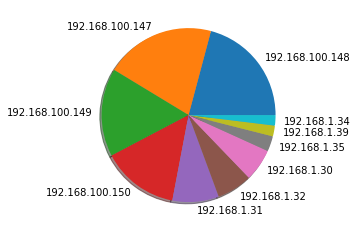

In [ ]:
#visualize top 10 src IPs
#running on top 10 for display purposes
src_ips = transactions['IPV4_SRC_ADDR'].value_counts()[:10]
plt.pie(src_ips, labels=src_ips.index, shadow = True)


PROTOCOL
1        2
2        1
6     1230
17     767
dtype: int64

TCP_FLAGS
0      770
2      543
16      11
17       3
18      23
19      34
20       4
22     202
23       9
24      14
25       2
26       1
27     135
28       1
30      47
31      27
211      3
214      3
219     63
222     48
223     57
dtype: int64

<BarContainer object of 4 artists>

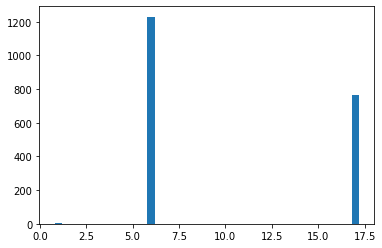

In [ ]:
#visualize PROTOCOL and TCP FLAGS 
proto = transactions['PROTOCOL'].value_counts()
#plt.pie(proto, labels=proto.index, shadow = True)

src_port = transactions['L4_SRC_PORT'].value_counts()
#plt.pie(src_port, labels=src_port.index, shadow = True)
#plt.scatter(x=transactions['L4_SRC_PORT'], y=transactions['PROTOCOL'])
tcp_flags = transactions['TCP_FLAGS'].value_counts()

#plt.scatter(x=transactions['TCP_FLAGS'], y=transactions['PROTOCOL'])
#tcp flag as 0 means not TCP
#what this shows is that when TCP flags are 0, the corresponding protocol is not TCP(UDP)

protos = transactions.groupby(['PROTOCOL']).size()
display(protos)
tcp_fls = transactions.groupby(['TCP_FLAGS']).size()
display(tcp_fls)

plt.bar(proto.index, proto.values, width=0.8)

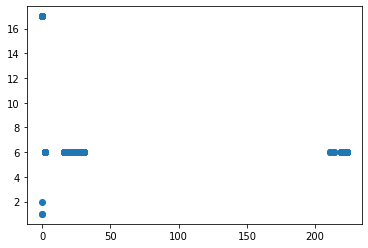

In [ ]:
plt.scatter(x=transactions['TCP_FLAGS'], y=transactions['PROTOCOL'])
#tcp flag as 0 means not TCP
#what this shows is that when TCP flags are 0, the corresponding protocol is not TCP(UDP)
#the 6 on the y axis has flags set the vast majority of the time

#Feature Engineering

In [121]:
from pandas.compat.numpy.function import TRANSPOSE_DEFAULTS
#Label, Dataset, and Attack are self explanatory regarding need to be dropped
#Dropping src/dst addresses as I want to predict on the characteristics of the transaction, not where it was going/coming from (private addresses); model
#might predict on address which means model might not be affective in other environments
#Still not 100% certain what L7_PROTO is in this context

#dropping : ['Label', 'Dataset', 'IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'L7_PROTO', 'FTP_COMMAND_RET_CODE', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'L4_SRC_PORT', 'L4_DST_PORT',]
features = ['PROTOCOL', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER']

#Initial Data conversion before sending to split and pipeline
#transactions['L4_SRC_PORT'] = transactions['L4_SRC_PORT'].astype(object)
#transactions['L4_DST_PORT'] = transactions['L4_DST_PORT'].astype(object)
transactions['PROTOCOL'] = transactions['PROTOCOL'].astype(object)
transactions['TCP_FLAGS'] = transactions['TCP_FLAGS'].astype(object)
transactions['ICMP_TYPE'] = transactions['ICMP_TYPE'].astype(object)
transactions['ICMP_IPV4_TYPE'] = transactions['ICMP_IPV4_TYPE'].astype(object)
transactions['DNS_QUERY_ID'] = transactions['DNS_QUERY_ID'].astype(object)
transactions['DNS_QUERY_TYPE'] = transactions['DNS_QUERY_TYPE'].astype(object)
transactions['DNS_TTL_ANSWER'] = transactions['DNS_TTL_ANSWER'].astype(object)
transactions['Label'] = transactions['Label'].astype(int)

keep = [17 , 6]

transactions = transactions[transactions['PROTOCOL'].isin(keep)]


#transactions.dtypes


IPV4_SRC_ADDR
L4_SRC_PORT
IPV4_DST_ADDR
L4_DST_PORT
PROTOCOL
L7_PROTO
IN_BYTES
IN_PKTS
OUT_BYTES
OUT_PKTS
TCP_FLAGS
CLIENT_TCP_FLAGS
SERVER_TCP_FLAGS
FLOW_DURATION_MILLISECONDS
DURATION_IN
DURATION_OUT
MIN_TTL
MAX_TTL
LONGEST_FLOW_PKT
SHORTEST_FLOW_PKT
MIN_IP_PKT_LEN
MAX_IP_PKT_LEN
SRC_TO_DST_SECOND_BYTES
DST_TO_SRC_SECOND_BYTES
RETRANSMITTED_IN_BYTES
RETRANSMITTED_IN_PKTS
RETRANSMITTED_OUT_BYTES
RETRANSMITTED_OUT_PKTS
SRC_TO_DST_AVG_THROUGHPUT
DST_TO_SRC_AVG_THROUGHPUT
NUM_PKTS_UP_TO_128_BYTES
NUM_PKTS_128_TO_256_BYTES
NUM_PKTS_256_TO_512_BYTES
NUM_PKTS_512_TO_1024_BYTES
NUM_PKTS_1024_TO_1514_BYTES
TCP_WIN_MAX_IN
TCP_WIN_MAX_OUT
ICMP_TYPE
ICMP_IPV4_TYPE
DNS_QUERY_ID
DNS_QUERY_TYPE
DNS_TTL_ANSWER
FTP_COMMAND_RET_CODE
Label
Attack
Dataset


In [100]:
#splits
X = transactions.loc[:, features]
y = transactions['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2435)

In [101]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (1500, 35)


,PROTOCOL,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,...,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER
755,6,40,1,0,0,2,0,0,0,0,...,0,0,0,1024,0,0,0,0,0,0
344,17,71,1,71,1,0,0,0,0,0,...,0,0,0,0,0,0,0,58462,1,0
797,17,56,2,0,0,0,4293811,1156,0,64,...,0,0,0,0,0,0,0,0,0,0
1090,17,68,1,100,1,0,0,0,0,0,...,0,0,0,0,0,0,0,49730,1,54
1094,17,112,4,0,0,0,4293935,1032,0,64,...,0,0,0,0,0,0,0,0,0,0



On X test: 
X test dimensions:  (500, 35)


,PROTOCOL,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,...,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER
356,6,2020,14,2179,11,223,0,0,0,103,...,1,1,1,8192,64000,0,0,0,0,0
1653,17,134,2,134,2,0,0,0,0,128,...,0,0,0,0,0,0,0,33200,28,0
500,17,58,1,160,1,0,0,0,0,0,...,0,0,0,0,0,0,0,57859,1,60
1179,6,1464,8,1873,7,30,0,0,0,103,...,1,1,1,8192,64000,0,0,0,0,0
1233,17,75,1,179,1,0,0,0,0,0,...,0,0,0,0,0,0,0,52629,1,52


In [102]:
# Y Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# Y test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (1500,)


755     0
344     1
797     1
1090    1
1094    1
Name: Label, dtype: int64


On y test: 
y test dimensions:  (500,)


356     0
1653    0
500     0
1179    0
1233    0
Name: Label, dtype: int64

#Test Pipeline

In [111]:
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])


preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

In [112]:
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', RandomForestClassifier())])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbc3ed5e390>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

In [113]:
pipe.predict_proba(X_test)

ValueError: ignored